(wrkflow-rap)=
# Reproducible Analysis

## Introduction

This chapter will tell you about reproducible analysis and what are sometimes called "reproducible analytical pipelines", also known as RAPs. This chapter has benefitted from the "[Quality Assurance of Code for Analysis and Research](https://best-practice-and-impact.github.io/qa-of-code-guidance)" book produced by the Best Practice and Impact division of the Office for National Statistics.

Reproducibility can mean a lot of things to a lot of different people in a lot of different contexts. Here, we're going to think about the reproducibility of analysis performed by code. That excludes external validity and although it might include robust coding practices, it doesn't include robustness checks.

It does include Reproducible Analytical Pipelines (RAPs), which are automated analytical processes. At their best, RAPs use elements of software engineering best practice to ensure that analysis is reproducible.

There are different levels and aspects of reproducibile analysis, which we will now step through.

## Using Modular Code

(You may have already met this idea before as the DRY, or "don't repeat yourself", concept).

How you structure your code can itself aid reproducibility. Let's imagine you have a situation where you want to perform two similar analytical tasks in which the only thing that changes are the inputs and outputs. Let's say, for example, that you want to perform a particular set of operations, perhaps the following:

> find the mean from the second entry in a list onwards, add 1, divide by the number of entries in the reduced length list and then print the answer as a score

Here's one example of that:

In [2]:
import numpy as np

list1 = [3, 4, 5, 6, 7, 8]
score1 = (np.mean(list1[1:]) + 1)/5
print(f"The score is {score1:.2f}")

The score is 1.40


But now we have imagine we have a second set of variables we'd like to run the same logic on. Naively, you might copy and paste the same code again but replace the list with the new one, like this:

In [3]:
list2 = [16, 12, 88, 1, 9, 7, 32, 5]
score2 = (np.mean(list2[1:]) + 1)/5
print(f"The score is {score2:.2f}")

The score is 4.60


The problem with this is that we repeated the code even though we wanted to perform the same operation, which is not very efficient.

We also expect `score1` and `score2` to be using the same operations, but we can't be sure now because *the code is different*. And indeed, in this case, the copy and paste philosophy has gone wrong. Did you spot the mistake? Instead of dividing by the number of entries in the reduced length list, our copy and paste job saw us dividing by the number of entries in the first case (creating `score1`).

What we should have done is create modular code, where the same logic is not repeated but *re-used*. In this case, that's best done with a function like follows:

In [4]:
def compute_score(list_input):
    """find the mean from the second entry in a list onwards,
    add 1, divide by the number of entries in the reduced
    length list and then print the answer as a score.

    Args:
        list_input (list[float]): A list of numbers
    Returns:
        score (float): A computed score
    """
    reduced_list = list_input[1:]
    score = (np.mean(reduced_list) + 1)/len(reduced_list)
    print(f"The score is {score:.2f}")

# Just to show it works:
compute_score(list1)
compute_score(list2)

The score is 1.40
The score is 3.29


We can now be sure that we get *exactly* the same set of operations applied each time because we put the logic into one function that is called for both lists. And, to avoid any copy and paste errors, we switched from hard-coding the divisor to making it part of the logic of the function (by dividing by `len(reduced_list)`).

By putting our logic in a function, we've also made what we are trying to do clearer to the reader—and remember, coders, that reader is most likely to be you in a few months time.

Functions help with reproducibile analytical pipelines because you can be sure that even if your inputs change slightly, the same logic or set of operations will be run.

Of course, functions do not have to be in the same script (the same `.py` file) as the one you are currently writing your code in. Python allows you to import functions from other scripts.

A classic example would be if you had a project that was structured like this:

```bash
📁 project
| main.py
| utilities.py
| figures.py
| README.md
```

where 'project' is a folder, and the files within it are three Python scripts and a markdown document. Your utilities script might have a really useful function in it that you'd like to use in main.py and figures.py too. You can do this! It's possible to do from 'within' your other scripts. It's also surprisingly simple. Your utilities script might look like:

In [5]:
# Contents of utilities.py file
def really_useful_func(number):
    """Performs a really useful operation on input number
    and returns the result."""
    return number*10


While, to use this function in your main.py script, you'd have:

In [6]:
# Contents of main.py
import utilities as util_mod

print(util_mod.really_useful_func(20))

200


And, just as valid, you could import the same function from utilities in a different way in figures.py

In [7]:
from utilities import really_useful_func

print(really_useful_func(30))

300


The technical jargon for what you've just done is to use `utilities.py` as a *module* rather than as a script.

```{note}
If your script is in a different directory, you will need a relative import. Let's say you've set your project's default directory to the folder "project", and the module you'd like to import is in a directory useful, so that it's path is `project/useful/utilities.py`. As before, you're running code from the default directory, `project/main.py`. Then you'll need to import the script within `main.py` using the following: `from useful import utilities as utils`.
```

The reasons for wanting to be able to import functions (or other code) from other scripts are exactly the same as for functions within scripts: so that you only need write the function once to use it everywhere, and so that you can be sure you are running exactly the same set of operations each time.

```{note}
If you are in the middle of a coding session and you change the code in a module (external script), your Python kernel will not necessarily know that you have changed the external script. You can either restart the Python kernel, but you lose your variables, or use the built-in `importlib` Python package. For example, to reload an external module named `utilities.py` that had been imported via `import utilities as utils`, you would run `import importlib` and, when you wanted to refresh the module, `importlib.reload(utils)`.
```

## Project Structure

The first principle to guide you should be that **each project lives in its own folder**. Everything for that project will appear somewhere under the top level directory. Do not mix projects in the same folder directory.

A typical project structure might look like:

```bash
📁 project
|-- README.md
|-- requirements.txt
|-- data/
|   -- raw_data.csv
|-- src/
|   -- utilities.py
|   -- data_cleaning.py
|   -- analysis.py
|   -- generate_plots_and_tables.py
|-- results/
|   -- cleaned_data.csv
|   -- derived_data.csv
|-- outputs/
|   -- latex/
|       -- paper.tex
|       -- slides.tex
|   -- floats/
|       -- table.tex
|       -- time_series_plot.pdf
```

Let's take a quick tour through this example project's structure, all of which sits in the "project" directory.

First we have the README.md, a file full of instructions in a simple text format called *markdown* (=".md"). Markdown is kind of like a code language for text and is commonly used to write information in coding projects. It can be "rendered" (that is, can be displayed not as code but in a form that is intended to be read) by Visual Studio Code using the markdown all in one extension (see the {ref}`code-where` chapter for more on markdown).

The next file, "requirements.txt", is one we'll be seeing much more of later in this chapter. For now, all you need to do know is that it is a list of all of the Python packages needed to run the project. Sometimes it might be called "environment.yml" instead, or sometimes "pyproject.toml".

Next we have the data, which is the data as you received it, no matter how poor the format (wishful thinking in this example that it might be a clean csv file and not 400 Excel files!). A really important principle here is that **you should not alter raw data** as it comes to you, but instead treat it as read-only. This is so that you can always trace a path from the raw data you began with to the finished product. Incoming data can and does change surprisingly often so if someone else were to do the "same" analysis as you and find a different answer, you want to be able to rule out starting with different input datasets as the cause. Or you may find that your data cleaning script needs adjusting, and you need to repeat all of the operations in your project. Or other good reasons. Always keep a copy of the raw data.

The next folder is "src", which is short for "source code", and it's where your code scripts (.py files) or possibly Jupyter Notebooks (.ipynb files) live. These are nicely separate into the functions they perform: cleaning the data, performing the analysis, and summarising the analysis into figures and tables (also known as floats). The other script, "utilities.py", might be imported as module that all of the other scripts can use.

The results from running the first two scripts are in the "results" folder. First we have a file that saves the results from the intermediate step of the cleaning the data (courtesy of running "data_cleaning.py"), then we have the results from "analysis.py", the derived data. Derived data might be, for example, the final tabular dataset that you use for a regression.

Next up is outputs, which is split into "latex" and "floats".

Latex is a typesetting language that is used for writing reports, slides, journal articles, and more. Importantly for coding and replicability, it can be automated (in a way that, say, Word can't be). Another option here would be markdown, which can also be exported to a wide variety of output formats. The text in a Latex report has to be written, we can't automate that (yet), but the figures and tables that are generated by the "generate_plots_and_tables.py" script can be automatically inserted. The same goes for slides written in a variant of Latex called Beamer. You can find more information on the process of automating reports and outputs in the chapter on {ref}`wrkflow-automating-outputs`.

Floats means, here at least, tables and figures. These also live in the outputs directory, and are put there by the "generate_plots_and_tables.py" script.

So that's the structure. There is another important principle here, which follows on from the first: **you should be able to dispose of the results, figures, and tables (ie delete them), without worrying**. If you are working on a project and deleting any outputs that are generated by code scripts would scupper everything, then your project is not reproducible. (This is another reason why you should always keep an "untouched" version of the raw data.) If it's feasible to do so time-wise, it is good practice to delete and regenerate your outputs regularly to test that your project is indeed reproducible.

TODO
There are, of course, many variations on this example project structure. You can find "cookiecutter" templates out there that will help you structure your own project (some involve answering some questions about what you need, and what you'd like to call project, and so on), or just get inspiration. Some good templates to check out that can help you structure your project are the UK Government data science, [govcookiecutter](https://github.com/ukgovdatascience/govcookiecutter), this comprehensive Python data science project template known as [cookiecutter-data-science](http://drivendata.github.io/cookiecutter-data-science/), and MY COOKIECUTTER. For advanced users looking to build Python packages that others can install, the [hypermodern Python cookiecutter]() is packed full of amazing features and comes highly recommended.

## Reproducible Analytical Pipelines

We've seen how functions and modules can aid the reproducibility of logic. We've seen the kind of folder and file structure that can aid reproducibility of projects too. But the *order* of operations matters as well! Pipelines organise your analysis in a series of steps that, when executed, perform the same series of operations in the same order. If you arrange your code in a reproducible analytical pipelines, you will know that you can send your code to someone else and, when they run it, the same steps will be executed in the same order.

In this section, we'll look at the concept in general as well as some tools that can aid you in creating reproducible analytical pipelines.

The first principle of RAPs may be a surprise: you shouldn't use the interactive console interactively (eg by jamming, re-running lines, etc, as you go). A RAP should be able to go from start to finish with zero human interaction during execution, and produce consistent results at the end. This is different to when you're still developing a project, and the interactive console is super useful because you're trying things out. But RAP is for prosperity and needs to work without your intervention!

### Directed Acyclic Graphs

Directed acyclic graphs pop up in lots of contexts. Here, in a RAP context, we're talking about them because the execution order of your code and scripts should form a directed acyclic graph (DAG). A DAG is a directed graph with no directed cycles (closed loops). It consists of vertices and edges (also called arcs), with each edge directed from one vertex to another, such that following those directions will never form a closed loop. The point is that the set of operations that are performed proceeds like water flowing through a series of rapids: one step after another, with no looping back.

This is all a bit abstract and it's a lot easier to just take a look at this visualisation of one. We'll use the example from the previous section.

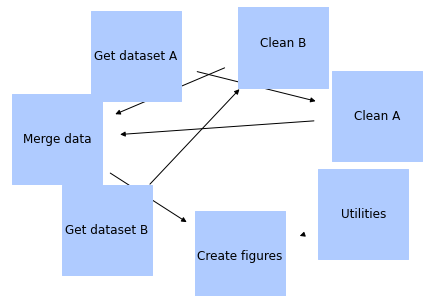

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

graph = nx.DiGraph()
graph.add_edges_from(
    [
        ("Utilities", "Clean A"),
        ("Utilities", "Create figures"),
        ("Get dataset A", "Clean A"),
        ("Get dataset B", "Clean B"),
        ("Clean A", "Merge data"),
        ("Clean B", "Merge data"),
        ("Merge data", "Create figures"),
    ]
)
colour_node = "#AFCBFF"
fixed_pos = nx.spring_layout(graph, seed=10, k=20, iterations=100)
nx.draw(graph, pos=fixed_pos, with_labels=True, node_size=8000, node_color=colour_node,
        node_shape="s")
plt.xlim(-1.3, 1.3)
plt.ylim(-1.3, 1.3)
plt.show();

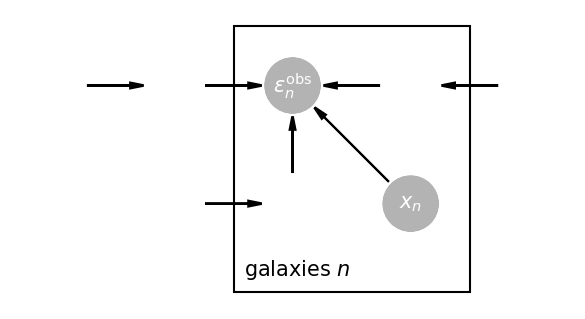

In [11]:
import daft

pgm = daft.PGM(node_ec="white", label_params={"color": "white"})
pgm.add_node("Omega", r"$\Omega$", -1, 4)
pgm.add_node("gamma", r"$\gamma$", 0, 4)
pgm.add_node("obs", r"$\epsilon^{\mathrm{obs}}_n$", 1, 4, observed=True)
pgm.add_node("alpha", r"$\alpha$", 3, 4)
pgm.add_node("true", r"$\epsilon^{\mathrm{true}}_n$", 2, 4)
pgm.add_node("sigma", r"$\sigma_n$", 1, 3)
pgm.add_node("Sigma", r"$\Sigma$", 0, 3)
pgm.add_node("x", r"$x_n$", 2, 3, observed=True)
pgm.add_plate([0.5, 2.25, 2, 2.25], label=r"galaxies $n$")
pgm.add_edge("Omega", "gamma")
pgm.add_edge("gamma", "obs")
pgm.add_edge("alpha", "true")
pgm.add_edge("true", "obs")
pgm.add_edge("x", "obs")
pgm.add_edge("Sigma", "sigma")
pgm.add_edge("sigma", "obs")

pgm.render(dpi=150);

In [ ]:
# TODO try dagitty

### Scripting Reproducible Analytical Pipelines

There's still a manual step in the above logic. Even with the raw data and the folder structure, someone needs to come along and remember to run the (right) three scripts in the right order. But there's no need to leave running the scripts in the right order to chance.

There are a few options to automate the execution order of the scripts. One is to write all the scripts as modules with a main script, "main.py", that runs everything else. The contents of main.py might look like this:

```python
""" main.py: Master script for project "project".
"""

import data_cleaning as dc
import analysis as analysis
import generate_plots_and_tables as gen_outputs

dc.run()
analysis.run()
gen_outputs.run()

```

With this arrangement, all the user has to know (perhaps from the README.md) is that they need to run "main.py" and it will take care of the rest. The code writer (often the same person as the user, but not always) does need to take the extra step of creating the relevant "run" functions in each of the three script files too though. And they need to ensure that *they* use main.py when generating their results (rather than running the scripts separately), because otherwise there may be differences.

### Make for Reproducible Analytical Pipelines

Make is a command line tool (to learn more about what the command line is, check out {ref}`wrkflow-command-line`) that helps with automating the execution of a series of processes.

To get Make, ...



## Reproducible Python Environments

## Reproducible Computational Environments

But it works on my computer!

## Saving Your Analysis For Prosperity

## An Example